In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# -------------------------------
# 1. Read the CSV files
# -------------------------------
train_csv = "train.csv"
test_csv = "test.csv"

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

print("First 5 rows of train.csv:")
print(train_df.head())
print("\nFirst 5 rows of test.csv:")
print(test_df.head())

# -------------------------------
# 2. Define custom datasets
# -------------------------------
class TrainImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.copy()
        self.transform = transform
        # Convert labels to integers if necessary.
        if self.df['label'].dtype == object:
            self.label_mapping = {label: idx for idx, label in enumerate(self.df['label'].unique())}
            self.df['label'] = self.df['label'].map(self.label_mapping)
            print("Label mapping:", self.label_mapping)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['file_name']
        if not os.path.isabs(img_path):
            img_path = os.path.join(os.getcwd(), img_path)
        image = Image.open(img_path).convert("RGB")
        label = int(row['label'])
        if self.transform:
            image = self.transform(image)
        return image, label

class TestImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.copy()
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['id']
        if not os.path.isabs(img_path):
            img_path = os.path.join(os.getcwd(), img_path)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, idx  # return idx as dummy label

# -------------------------------
# 3. Define image transformations
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create dataset instances
full_train_dataset = TrainImageDataset(train_df, transform=transform)
full_test_dataset = TestImageDataset(test_df, transform=transform)

# -------------------------------
# 4. Reduce dataset size and split train into training and validation sets
# -------------------------------
max_train_samples = 300
max_test_samples = 200

# Create a subset of the full training dataset and test dataset.
train_subset = Subset(full_train_dataset, list(range(min(max_train_samples, len(full_train_dataset)))))
test_subset = Subset(full_test_dataset, list(range(min(max_test_samples, len(full_test_dataset)))))

# Split the train_subset: 70% training, 30% validation.
train_len = int(0.7 * len(train_subset))
val_len = len(train_subset) - train_len
train_split, val_split = random_split(train_subset, [train_len, val_len])

batch_size = 32
train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_split, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# -------------------------------
# 5. Define a small CNN model
# -------------------------------
class SmallCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SmallCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # from 3 channels to 32
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 128 -> 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 32 -> 64 channels
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64 -> 32
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 64 -> 128 channels
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 32 -> 16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Determine number of classes from train.csv.
num_classes = len(train_df['label'].unique())
print("Number of classes:", num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=num_classes).to(device)
print(model)

# -------------------------------
# 6. Define loss function and optimizer
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------------
# 7. Training loop with tqdm and metrics tracking
# -------------------------------
num_epochs = 10  # Fewer epochs for faster training
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    
    epoch_loss = running_loss / len(train_split)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {epoch_loss:.4f}")
    
    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = correct / total
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Accuracy: {val_acc:.4f}")

# (Optional) Save the trained model
torch.save(model.state_dict(), "small_model.pth")


KeyboardInterrupt: 

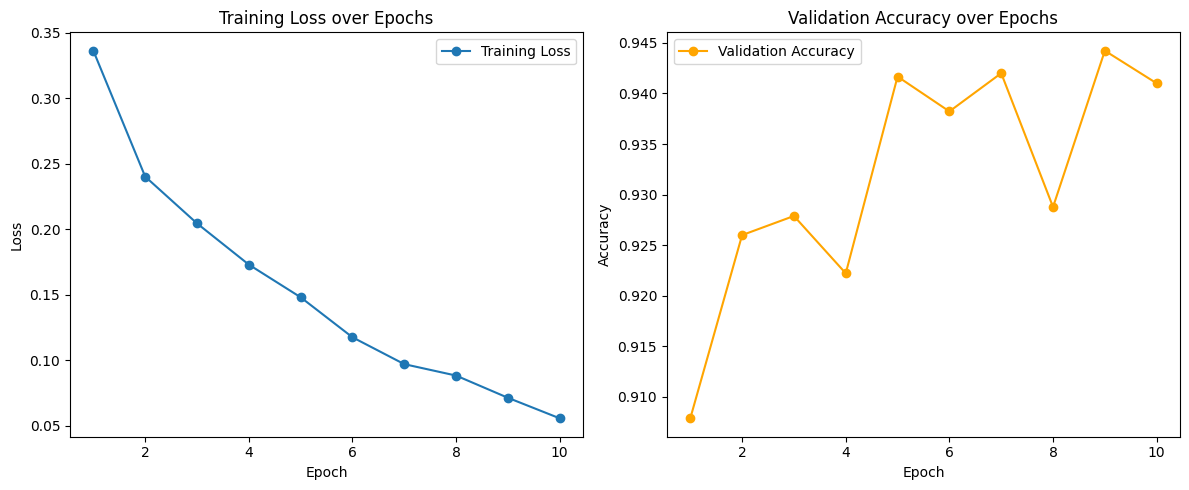

In [ ]:
# -------------------------------
# 8. Plot training metrics and save to PDF
# -------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, marker='o', color='orange', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.savefig("training_metrics.pdf", format="pdf")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
import torch

# Mapping for labels: adjust as needed.
label_names = {0: "AI Image", 1: "Real Image"}

# Inverse normalization transform to revert the normalization applied during training.
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

# Use the validation dataset (from random_split).
ds = val_split  # Ensure this variable is defined from your earlier code

# Set up grid parameters
num_show = 30   # Show 30 images
rows, cols = 5, 6  # Arrange in 5 rows x 6 columns
fig, axes = plt.subplots(rows, cols, figsize=(18, 15))
axes = axes.flatten()

model.eval()  # Ensure the model is in evaluation mode

for i in range(num_show):
    # Get the image and its true label from the validation dataset.
    image, true_label = ds[i]
    # Add a batch dimension and move to device.
    image_tensor = image.unsqueeze(0).to(device)
    
    # Get model prediction and probabilities.
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        prob, pred = torch.max(probabilities, 1)
    
    # Create a title text showing both predicted and true labels.
    pred_text = (f"Pred: {label_names[pred.item()]} ({prob.item()*100:.1f}%)\n"
                 f"True: {label_names[true_label]}")
    
    # Inverse normalize for display.
    image_disp = inv_normalize(image).permute(1, 2, 0).cpu().numpy()
    image_disp = image_disp.clip(0, 1)
    
    axes[i].imshow(image_disp)
    axes[i].set_title(pred_text, fontsize=12)
    axes[i].axis("off")

plt.tight_layout()
# Save the figure as a PDF file.
plt.savefig("val_predictions.pdf", format="pdf")
plt.show()


NameError: name 'val_split' is not defined